## Set-up

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from tqdm import tqdm

In [2]:
# JSON 파일 경로와 이미지 경로 설정
json_path = '/root/data/datasets/jsons/train.json'
image_base_path = '/root/data/datasets/images/train/'
output_path = '/root/data/datasets/remove_background/'

# JSON 파일 로드
with open(json_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

In [3]:
image_names = list(data['images'].keys())

In [10]:
# def show_anns(anns):
def show_anns(anns, tmp):
    if len(anns) == 0:
        return
    idx = 0

    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        if idx == tmp:
            break
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
        idx += 1
    ax.imshow(img)

In [5]:
def visualize_with_red_mask(result_dict, image, image_name):
    # 결과를 area 기준으로 정렬
    sorted_results = sorted(result_dict, key=lambda x: x['area'], reverse=True)
    
    # 가장 큰 segment 가져오기
    largest_segment = sorted_results[0]
    
    # segmentation mask 가져오기
    segmentation_mask = largest_segment['segmentation']
    
    # 원본 이미지 복사
    overlay_image = image.copy()
    
    # 붉은색 투명 마스크 적용
    red_mask = np.zeros_like(image, dtype=np.uint8)
    red_mask[segmentation_mask] = [0, 0, 255]  # 붉은색 (BGR 포맷)
    
    # 투명도 적용 (0.5 투명한 마스크)
    alpha = 0.5
    overlay_image = cv2.addWeighted(red_mask, alpha, overlay_image, 1 - alpha, 0)

    # 시각화
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))  # OpenCV는 BGR이므로 RGB로 변환
    plt.axis('off')
    plt.title(f"Largest Segment {image_name}")
    plt.show()

In [6]:
def save_largest_segment_without_mask(result_dict, image, output_path, image_name):
    # 결과를 area 기준으로 정렬
    sorted_results = sorted(result_dict, key=lambda x: x['area'], reverse=True)
    
    # 가장 큰 segment 가져오기
    largest_segment = sorted_results[0]
    
    # segmentation mask 가져오기
    segmentation_mask = largest_segment['segmentation']
    
    # 마스크 적용하여 해당 부분만 추출
    mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    mask[segmentation_mask] = 1  # 마스크 부분을 1로 설정
    
    # 이미지에 마스크 적용해서 해당 부분만 추출
    segmented_image = cv2.bitwise_and(image, image, mask=mask)

    # Bounding box를 사용해 해당 영역만 crop
    x, y, w, h = largest_segment['bbox']
    x , y, w, h = int(x), int(y), int(w), int(h)
    cropped_segment = segmented_image[y:y+h, x:x+w]

    # plt.figure(figsize=(10, 10))
    # plt.imshow(cv2.cvtColor(cropped_segment, cv2.COLOR_BGR2RGB))  # OpenCV는 BGR이므로 RGB로 변환
    # plt.axis('off')
    # plt.title(f"Largest Segment {image_name}")
    # plt.show()

    # 결과 저장
    cv2.imwrite(output_path+image_name, cropped_segment)
    # print(f"Segmented image saved to {output_path+image_name}")

In [36]:
def adjust_data(original_data, adjusted_data, image_name, result_dict):
    # 원본 이미지에서 자른 영역의 좌상단 좌표 (x, y)
    sorted_results = sorted(result_dict, key=lambda x: x['area'], reverse=True)
    largest_segment = sorted_results[0]

    cropped_x, cropped_y, _, _ = largest_segment['bbox']  # 자른 이미지의 좌표 값
    cropped_x = int(cropped_x)
    cropped_y = int(cropped_y)

    # 좌표 조정
    
    image_data = original_data['images'][image_name]
    adjusted_words = {}
    for word_id, word_info in image_data['words'].items():
        points = word_info['points']
        
        # 모든 좌표에서 자른 좌표의 (x, y)를 빼줌
        adjusted_points = [
            [point[0] - cropped_x, point[1] - cropped_y] for point in points
        ]
        
        # 조정된 points를 저장
        adjusted_words[word_id] = {
            'points': adjusted_points,
            'orientation': word_info['orientation'],
            'language': word_info['language']
        }
        
    #     adjusted_data['images'][image_name] = {'words': adjusted_words}
    # return adjusted_data
    return {'words': adjusted_words}

## Example image

In [17]:
image_base_path='/root/data/datasets/remove_background/test/'
image = cv2.imread(image_base_path+'drp.en_ko.in_house.selectstar_000192.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [8]:
image = cv2.imread(image_base_path+image_names[4])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

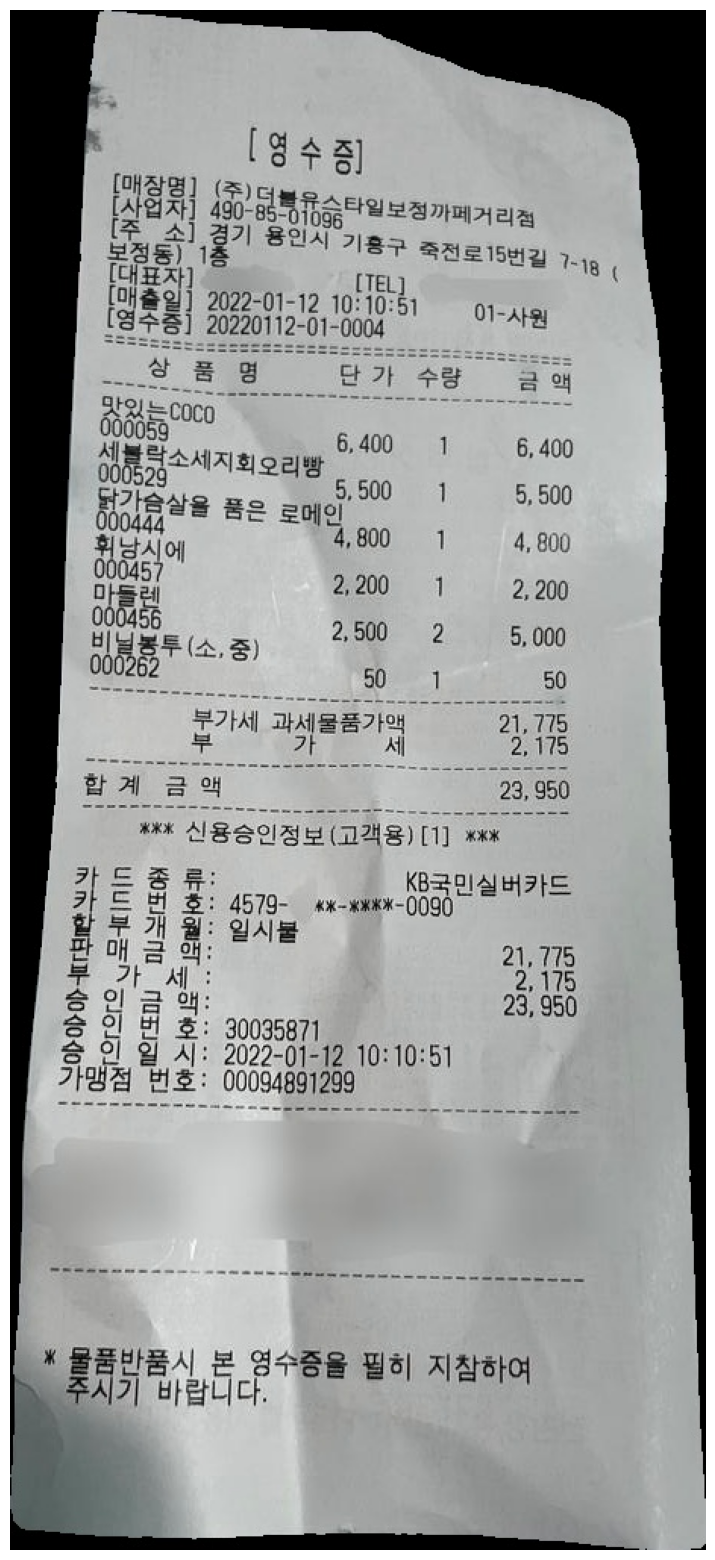

In [18]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [19]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [43]:
print(len(masks))
print(masks[0].keys())

74
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

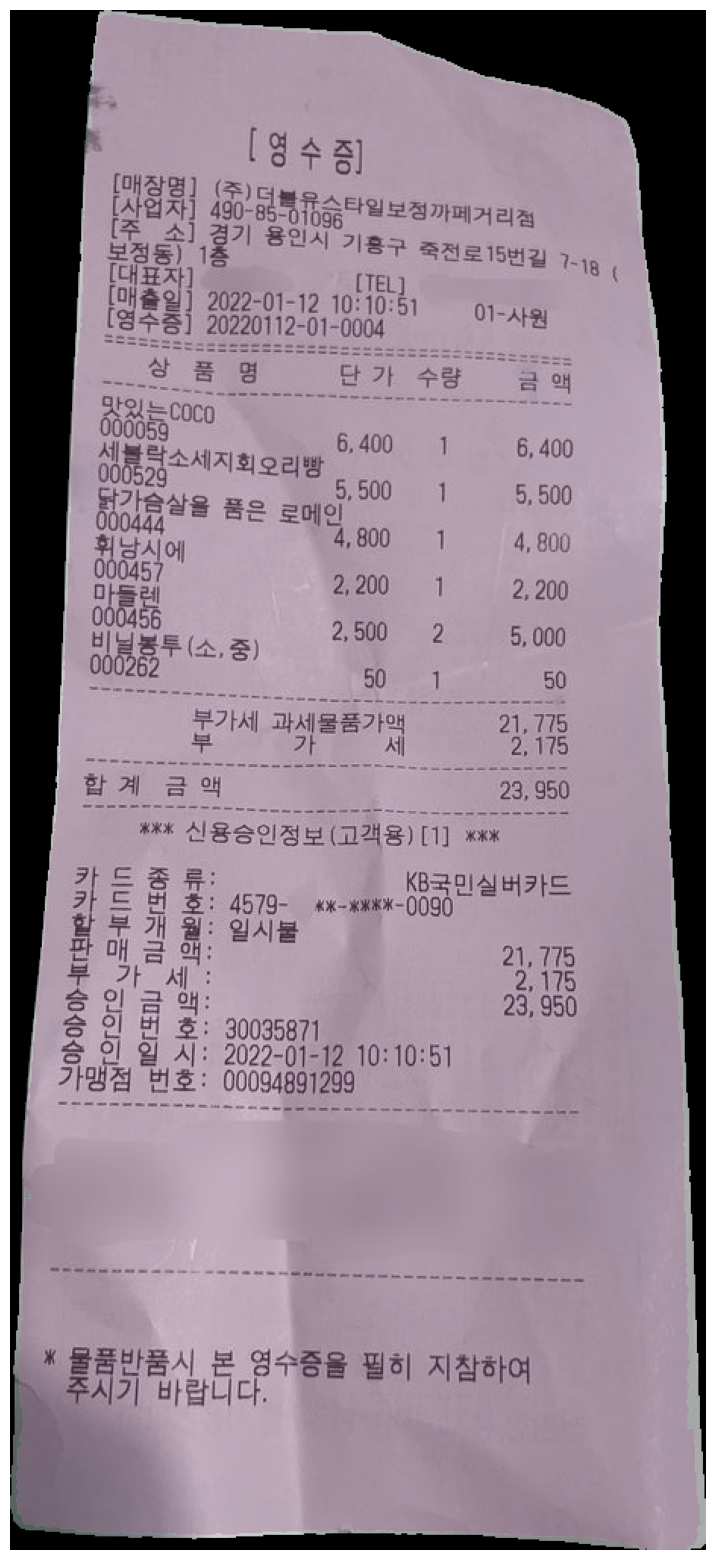

In [21]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks,1)
plt.axis('off')
plt.show() 

# train, vald, test data에 적용 및 json 파일 수정

In [42]:
# JSON 파일 경로와 이미지 경로 설정
json_path = '/root/data/datasets/jsons/train.json'
image_base_path = '/root/data/datasets/images/train/'
output_path = '/root/data/datasets/remove_background/train/'

# JSON 파일 로드
with open(json_path, 'r', encoding='utf-8') as f:
    train_data = json.load(f)

In [43]:
# 수정한 json파일
adjusted_data = {'images': {}}

# for image_json, i in zip(data['images'].items(), range(5)):
for image_json in tqdm(train_data['images'].items()):
    # 임시 횟수 제한
    # if i == 5:
    #     break
    image_name, image_data = image_json

    image = cv2.imread(image_base_path+image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    masks = mask_generator.generate(image)

    # 수정한 json을 저장
    # adjusted_data = adjust_data(train_data, adjusted_data, image_name, masks)
    adjusted_data['images'][image_name] = adjust_data(train_data, adjusted_data, image_name, masks)

    # visualize_with_red_mask(masks, image, image_name)
    # save_largest_segment_without_mask(masks, image, output_path, image_name)
# 조정된 JSON 파일 저장
# with open('../../datasets/jsons/adjusted_train.json', 'w') as f:
#     json.dump(adjusted_data, f, indent=4)

with open('./adjusted_train.json', 'w') as f:
    json.dump(adjusted_data, f, indent=4)

100%|██████████| 3272/3272 [2:09:03<00:00,  2.37s/it]  


In [39]:
# JSON 파일 경로와 이미지 경로 설정
json_path = '/root/data/datasets/jsons/val.json'
image_base_path = '/root/data/datasets/images/val/'
output_path = '/root/data/datasets/remove_background/val/'

# JSON 파일 로드
with open(json_path, 'r', encoding='utf-8') as f:
    val_data = json.load(f)

In [40]:
# 수정한 json파일
adjusted_data = {'images': {}}

# for image_json, i in zip(data['images'].items(), range(5)):
for image_json in tqdm(val_data['images'].items()):
    # 임시 횟수 제한
    # if i == 5:
    #     break
    image_name, image_data = image_json

    image = cv2.imread(image_base_path+image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    masks = mask_generator.generate(image)

    # 수정한 json을 저장
    # result_json = adjust_data(val_data, adjusted_data, image_name, masks)
    adjusted_data['images'][image_name] = adjust_data(val_data, adjusted_data, image_name, masks)

    # visualize_with_red_mask(masks, image, image_name)
    # save_largest_segment_without_mask(masks, image, output_path, image_name)
# 조정된 JSON 파일 저장
# with open('/root/data/datasets/jsons/adjusted_val.json', 'w') as f:
#     json.dump(adjusted_data, f, indent=4)

with open('./adjusted_val.json', 'w') as f:
    json.dump(adjusted_data, f, indent=4)
# with open('./adjusted_val1.json', 'w') as f:
#     json.dump(result_json, f, indent=4)

100%|██████████| 404/404 [16:02<00:00,  2.38s/it]


In [15]:
# JSON 파일 경로와 이미지 경로 설정
json_path = '/root/data/datasets/jsons/test.json'
image_base_path = '/root/data/datasets/images/test/'
output_path = '/root/data/datasets/remove_background/test/'

# JSON 파일 로드
with open(json_path, 'r', encoding='utf-8') as f:
    test_data = json.load(f)

In [16]:
# 수정한 json파일
adjusted_data = {'images': {}}

# for image_json, i in zip(data['images'].items(), range(5)):
for image_json in tqdm(test_data['images'].items()):
    # 임시 횟수 제한
    # if i == 5:
    #     break
    image_name, image_data = image_json

    image = cv2.imread(image_base_path+image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    masks = mask_generator.generate(image)

    # 수정한 json을 저장
    adjusted_data = adjust_data(test_data, adjusted_data, image_name, masks)

    # visualize_with_red_mask(masks, image, image_name)
    # save_largest_segment_without_mask(masks, image, output_path, image_name)
# 조정된 JSON 파일 저장
# with open('/root/data/datasets/jsons/adjusted_test.json', 'w') as f:
#     json.dump(adjusted_data, f, indent=4)

with open('./adjusted_test.json', 'w') as f:
    json.dump(adjusted_data, f, indent=4)

  5%|▍         | 19/413 [00:45<16:03,  2.44s/it]

100%|██████████| 413/413 [16:23<00:00,  2.38s/it]
